# Question Number 3 

https://github.com/nehrjv/Deep-Learning-lab-Assignment/tree/main

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras import regularizers
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.initializers import he_uniform, glorot_normal, zeros, ones
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

C:\Users\Acer\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Acer\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Acer\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Acer\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (

In [2]:
# loading dataset
# dictionaries with keys `X` and `y` for the input images and labels respectively.

# loading dataset
# dictionaries with keys `X` and `y` for the input images and labels respectively.
train = loadmat('E:/MLP_classifier/train/train_32x32.mat')
test = loadmat('E:/MLP_classifier/test/test_32x32.mat')


In [3]:
def show_images(n,image_array,label_array, cmap=None):
    '''
    show random n number of images from image_array with corresponding label_array
    '''
    total_rows = math.floor(n/4)+1
    random_list = random.sample(range(0, image_array.shape[0]), n)
    fig, axes = plt.subplots(total_rows, 4, figsize=(16, total_rows*4))
    [axi.set_axis_off() for axi in axes.ravel()] # this line sets all axis off
    r = 0
    c = 0
    for i in random_list:
        image = image_array[i,:,:,:]
        #axes[r, c].set_axis_off()
        axes[r, c].imshow(np.squeeze(image), cmap=cmap)
        axes[r, c].set_title(f"Label: {label_array[i]} \n {i}th image in the dataset.")
        c += 1
        if c % 4 == 0:
            r += 1
            c = 0
    plt.show()

In [4]:
def show_images_predictions(n,image_array,label_array1,label_array2, cmap=None):
    '''
    show random n number of images from image_array with corresponding label_array
    the precition of class probablity distibution from each model also would be discplayed
    '''
    random_list = random.sample(range(0, image_array.shape[0]), n)
    fig, axes = plt.subplots(n, 2, figsize=(16, n*6))
    #[axi.set_axis_off() for axi in axes.ravel()] # this line sets all axis off
    category_list1 = list(map(lambda x : x + 0.15, list(range(10)))) 
    category_list2 = list(map(lambda x : x - 0.15, list(range(10)))) 
    r = 0
    for i in random_list:
        image = image_array[i,:,:,:]
        axes[r, 0].set_axis_off()
        axes[r, 0].imshow(np.squeeze(image), cmap=cmap)
        #axes[r, 1].set_title(f"{i}th image in the dataset.")
        axes[r, 1].bar(category_list1,label_array1[i], width=0.3, label='MLP')
        axes[r, 1].bar(category_list2,label_array2[i], width=0.3, label='CNN')
        axes[r, 1].set_title(f"Prediction from MLP model: {np.argmax(label_array1[i,:])} \n Prediction from CNN model: {np.argmax(label_array2[i,:])} ")
        axes[r, 1].legend()
        r += 1
    plt.show()

In [5]:
# Functions to plot accuacy and loss
def plot_acc(history):
    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    except KeyError:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show() 


def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

In [6]:
train_images = train['X'] 
train_labels = train['y']
test_images = test['X'] 
test_labels = test['y']

# scaling the numbers
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshaping the inputs
train_images = np.moveaxis(train_images,-1,0)
test_images = np.moveaxis(test_images,-1,0)

# changing 0 number label from 10 to 0
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0

In [7]:

train_images_grey = np.mean(train_images, axis=3)
train_images_grey = np.expand_dims(train_images_grey, axis=3) # add the channel dimension
test_images_grey = np.mean(test_images, axis=3)
test_images_grey = np.expand_dims(test_images_grey, axis=3) # add the channel dimension

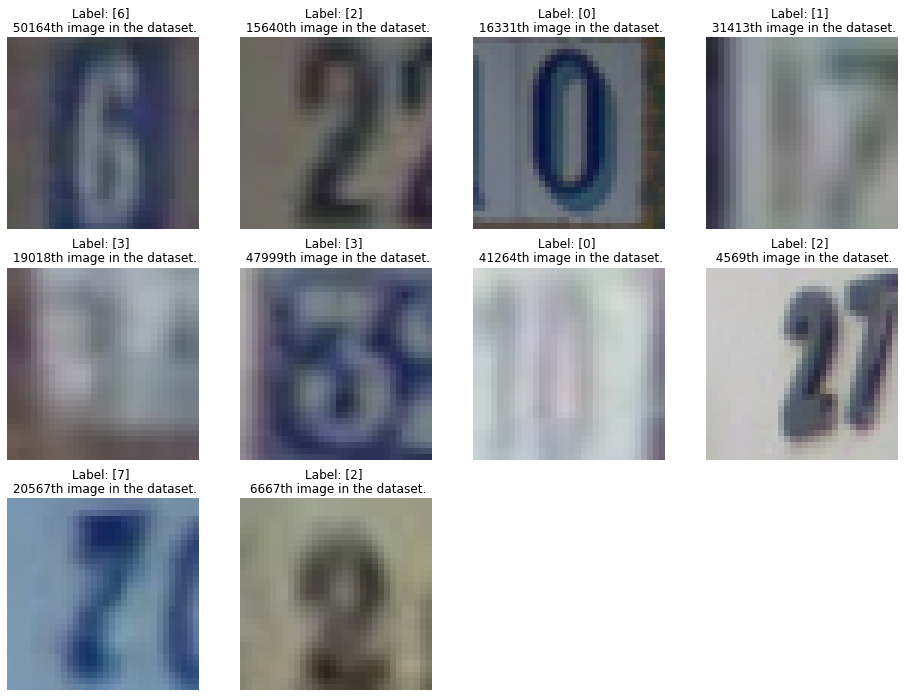

In [8]:
n = 10 # number of images to show
# showing images and correspoind labels from train set
show_images(n,train_images,train_labels)

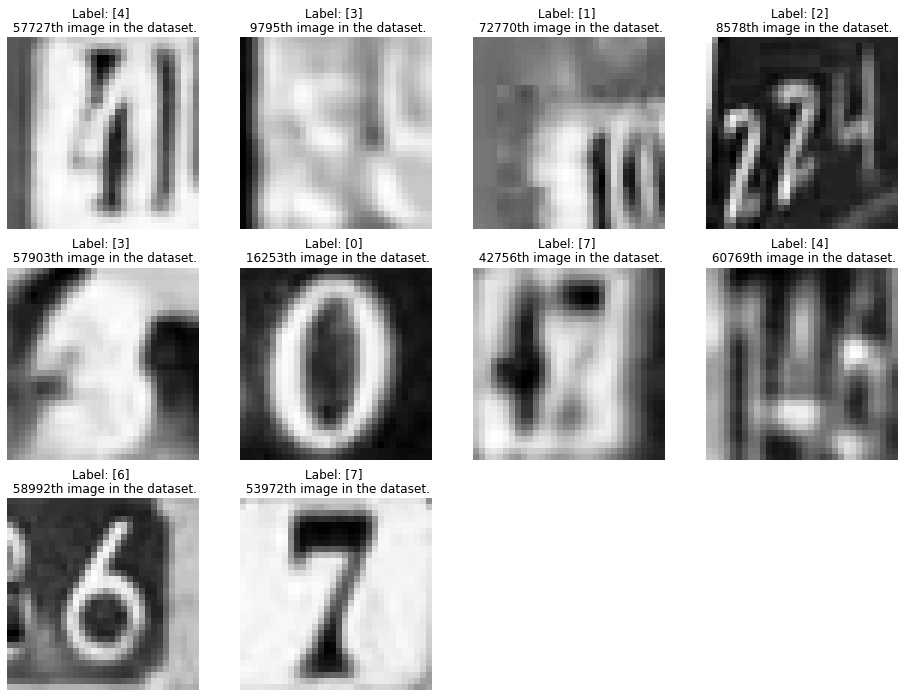

In [9]:
n = 10 # number of images to show
# showing greay images and correspoind labels from train set
show_images(n,train_images_grey,train_labels, cmap='Greys')

In [10]:
def MLP_NN(input_shape, reg_rate):
    '''
    Multilayer Perceptron (MLP) classification model
    '''
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(256, activation='relu', kernel_initializer="he_uniform", bias_initializer="ones",
              kernel_regularizer=regularizers.l2(reg_rate), name='dense_1_relu'),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='dense_2_relu'),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='dense_3_relu'),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='dense_4_relu'),
        Dense(10, activation='softmax', name='dense_5_softmax')
    ])
    return model

In [11]:
def get_checkpoint_best_only(checkpoint_path):
    '''
    save best weights of the model with monitoring validation accuract
    '''
    checkpoint = ModelCheckpoint(checkpoint_path,
                                 save_weights_only=True,
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=True)
    
    return checkpoint

In [12]:
def get_test_accuracy(model, x_test, y_test):
    '''
    checking the accuracy of the model on the test sets
    '''
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(' test accuracy: {acc:0.3f}'.format(acc=test_acc), '\n',
          'test loss: {loss:0.3f}'.format(loss=test_loss))

In [13]:
# creating MLP model for greay scale images
model_MLP = MLP_NN(input_shape=(32,32,1), reg_rate=1e-4)
model_MLP.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_1_relu (Dense)         (None, 256)               262400    
_________________________________________________________________
dense_2_relu (Dense)         (None, 256)               65792     
_________________________________________________________________
dense_3_relu (Dense)         (None, 128)               32896     
_________________________________________________________________
dense_4_relu (Dense)         (None, 128)               16512     
_________________________________________________________________
dense_5_softmax (Dense)      (None, 10)                1290      
Total params: 378,890
Trainable params: 378,890
Non-trainable params: 

In [14]:

model_MLP.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [15]:
checkpoint_best_only = get_checkpoint_best_only('E:/MLP_classifier/Trained models weights_English/checkpoints_best_only_MLP/checkpoint')

history_MLP = model_MLP.fit(train_images_grey,
                            train_labels,
                            batch_size=64,
                            epochs=30,
                            validation_split=0.10,
                            callbacks=[EarlyStopping(monitor='val_accuracy', patience=4), checkpoint_best_only]
                           )

Train on 65931 samples, validate on 7326 samples
Epoch 1/30
65931/65931 [==============================] - 6s 90us/sample - loss: 2.0656 - acc: 0.2828 - val_loss: 1.7467 - val_acc: 0.4085
Epoch 2/30
65931/65931 [==============================] - 5s 81us/sample - loss: 1.3836 - acc: 0.5547 - val_loss: 1.2088 - val_acc: 0.6323
Epoch 3/30
65931/65931 [==============================] - 5s 83us/sample - loss: 1.1564 - acc: 0.6452 - val_loss: 1.1523 - val_acc: 0.6375
Epoch 4/30
65931/65931 [==============================] - 6s 87us/sample - loss: 1.0530 - acc: 0.6799 - val_loss: 1.0047 - val_acc: 0.6945
Epoch 5/30
65931/65931 [==============================] - 6s 94us/sample - loss: 0.9830 - acc: 0.7034 - val_loss: 0.9129 - val_acc: 0.7235
Epoch 6/30
65931/65931 [==============================] - 6s 87us/sample - loss: 0.9332 - acc: 0.7219 - val_loss: 0.9585 - val_acc: 0.7095
Epoch 7/30
65931/65931 [==============================] - 6s 88us/sample - loss: 0.8906 - acc: 0.7355 - val_loss: 0.8

65931/65931 [==============================] - 6s 93us/sample - loss: 0.7061 - acc: 0.8026 - val_loss: 0.8737 - val_acc: 0.7548
Epoch 20/30
65931/65931 [==============================] - 6s 90us/sample - loss: 0.6946 - acc: 0.8082 - val_loss: 0.7659 - val_acc: 0.7858
Epoch 21/30
65931/65931 [==============================] - 6s 98us/sample - loss: 0.6858 - acc: 0.8131 - val_loss: 0.7750 - val_acc: 0.7865
Epoch 22/30
65931/65931 [==============================] - 6s 85us/sample - loss: 0.6704 - acc: 0.8160 - val_loss: 0.7155 - val_acc: 0.8040
Epoch 23/30
65931/65931 [==============================] - 6s 85us/sample - loss: 0.6671 - acc: 0.8187 - val_loss: 0.7458 - val_acc: 0.7950
Epoch 24/30
65931/65931 [==============================] - 5s 83us/sample - loss: 0.6552 - acc: 0.8209 - val_loss: 0.7525 - val_acc: 0.7951
Epoch 25/30
65931/65931 [==============================] - 6s 84us/sample - loss: 0.6569 - acc: 0.8217 - val_loss: 0.7421 - val_acc: 0.8008
Epoch 26/30
65931/65931 [=======

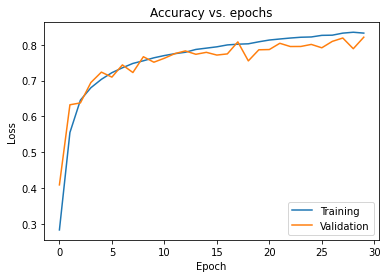

In [16]:
plot_acc(history_MLP)

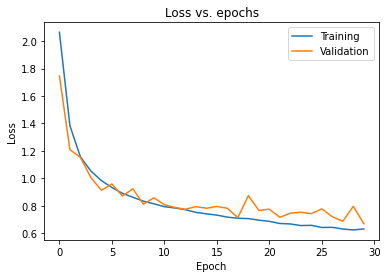

In [17]:
plot_loss(history_MLP)

In [18]:

get_test_accuracy(model_MLP, test_images_grey, test_labels)

 test accuracy: 0.803 
 test loss: 0.783


In [19]:
def get_model_best_epoch(model, checkpoint_path):
    '''
    get model saved best epoch
    '''
    model.load_weights(checkpoint_path)
    
    return model

In [20]:
prediction_MLP = model_MLP.predict(test_images_grey)
prediction_MLP_final = np.argmax(prediction_MLP, axis=1) # finding the maximum category
prediction_MLP_final = np.expand_dims(prediction_MLP_final, axis=1) # add the channel dimension

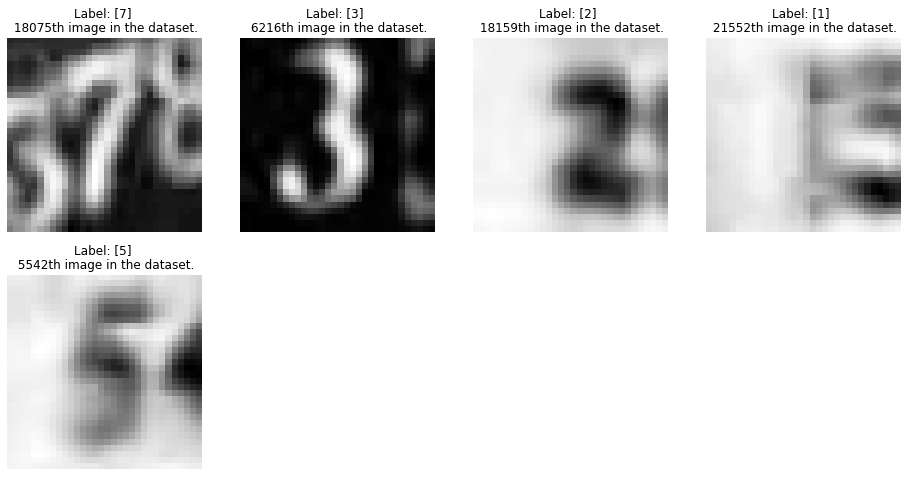

In [21]:
n = 5 # number of images to show
show_images(n,test_images_grey,prediction_MLP_final, cmap='Greys')